In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.core import SpatialDropout2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetV2L, DenseNet201, VGG19
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from keras.models import load_model
import itertools 
filterwarnings('ignore')
np.random.seed(101)
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Wed Dec 28 15:40:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_dir ="/content/drive/MyDrive/RiceLeaf/train"
val_dir = "/content/drive/MyDrive/RiceLeaf/validation"
test_dir="/content/drive/MyDrive/RiceLeaf/validation"
labels = ['bacterial_leaf_blight','brown_spot','healthy','leaf_blast','leaf_scald','narrow_brown_spot']
label_np=np.array(labels)

In [5]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 101
set_seed(seed)

In [6]:
model1 = EfficientNetV2L(include_top=False,input_shape=(299, 299,3), weights='imagenet')
input_shape = (299, 299)

473176280/473176280 [==============================] - 21s 0us/step


In [7]:
model2 = DenseNet201(include_top=False,input_shape=(299, 299,3), weights='imagenet')
input_shape = (299, 299)

74836368/74836368 [==============================] - 4s 0us/step


In [8]:
model3 = VGG19(include_top=False,input_shape=(299, 299,3), weights='imagenet')
input_shape = (299, 299)

80134624/80134624 [==============================] - 4s 0us/step


In [9]:
datagen_train = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

datagen_val=ImageDataGenerator(rescale=1./255)

batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                        
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
generator_test=datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 2167 images belonging to 6 classes.
Found 543 images belonging to 6 classes.
Found 543 images belonging to 6 classes.


In [10]:
headModel = model1.output
headModel = layers.Flatten()(headModel) 
headModel = Dense(6, activation="softmax")(headModel)
modelA = Model(inputs=model1.input, outputs=headModel)
modelA.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
headModel = model2.output
headModel = layers.Flatten()(headModel) 
headModel = Dense(6, activation="softmax")(headModel)
modelB = Model(inputs=model2.input, outputs=headModel)
modelB.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 305, 305, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 150, 150, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [12]:
headModel = model3.output
headModel = layers.Flatten()(headModel) 
headModel = Dense(6, activation="softmax")(headModel)
modelC = Model(inputs=model3.input, outputs=headModel)
modelC.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [13]:
import tensorflow as tf
models = [modelA,modelB,modelC]
model_input = tf.keras.Input(shape=(299, 299, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.models.Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 6)            118514854   ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 6)            19255110    ['input_4[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 6)            20273222    ['input_4[0][0]']         

In [14]:
from keras import backend as K
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def Specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [15]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['accuracy', Precision, Recall, F1, Specificity]
ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

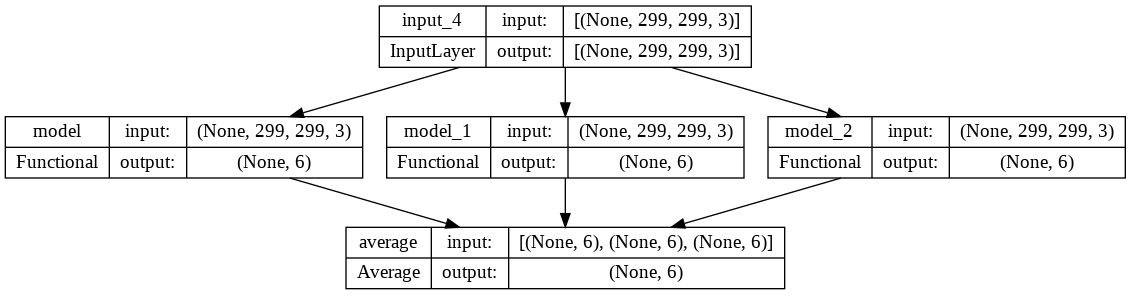

In [16]:
tf.keras.utils.plot_model(ensemble_model, 'model.png', show_shapes= True)

In [17]:

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

earlystopping = EarlyStopping(monitor ="val_loss", 
                              mode ="min", patience = 3, 
                              restore_best_weights = True)
history = ensemble_model.fit_generator(generator=generator_train,
                              epochs=50,
                              validation_data=generator_val,
                              validation_steps=steps_test,
                              callbacks =[earlystopping]
                              )


Epoch 1/50
271/271 [==============================] - 1708s 6s/step - loss: 0.8018 - accuracy: 0.7185 - Precision: 0.7740 - Recall: 0.5380 - F1: 0.6160 - Specificity: 0.9832 - val_loss: 0.4962 - val_accuracy: 0.8416 - val_Precision: 0.9099 - val_Recall: 0.7298 - val_F1: 0.7941 - val_Specificity: 0.9871
Epoch 2/50
271/271 [==============================] - 403s 1s/step - loss: 0.3186 - accuracy: 0.9036 - Precision: 0.9396 - Recall: 0.8583 - F1: 0.8938 - Specificity: 0.9889 - val_loss: 0.3331 - val_accuracy: 0.9061 - val_Precision: 0.9353 - val_Recall: 0.8640 - val_F1: 0.8945 - val_Specificity: 0.9886
Epoch 3/50
271/271 [==============================] - 403s 1s/step - loss: 0.1831 - accuracy: 0.9566 - Precision: 0.9667 - Recall: 0.9354 - F1: 0.9498 - Specificity: 0.9935 - val_loss: 0.1996 - val_accuracy: 0.9411 - val_Precision: 0.9456 - val_Recall: 0.9283 - val_F1: 0.9363 - val_Specificity: 0.9893
Epoch 4/50
271/271 [==============================] - 401s 1s/step - loss: 0.1325 - accura

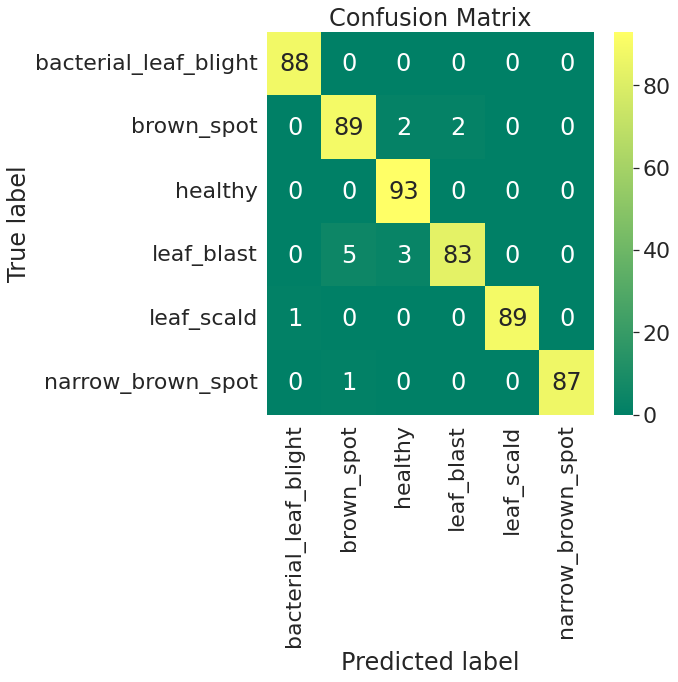

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_pred = ensemble_model.predict_generator(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(generator_test.classes, y_pred)
df_cm = pd.DataFrame(array, index =['bacterial_leaf_blight','brown_spot','healthy','leaf_blast','leaf_scald','narrow_brown_spot'],
                  columns = ['bacterial_leaf_blight','brown_spot','healthy','leaf_blast','leaf_scald','narrow_brown_spot'])
plt.figure(figsize=(10,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap='summer', fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('model1_confusion',dpi=200); 
plt.show()

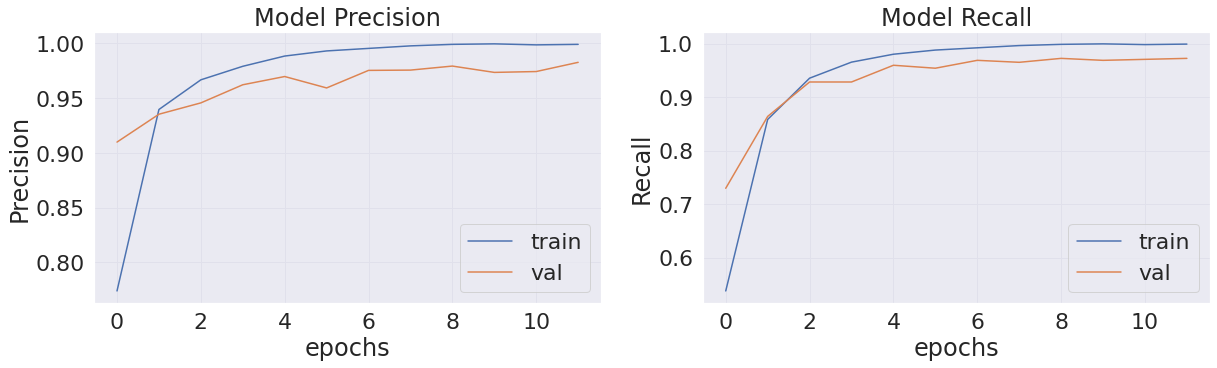

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['Precision', 'Recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'])

fig.savefig('model1_Precision_Recall_',dpi=1200); 

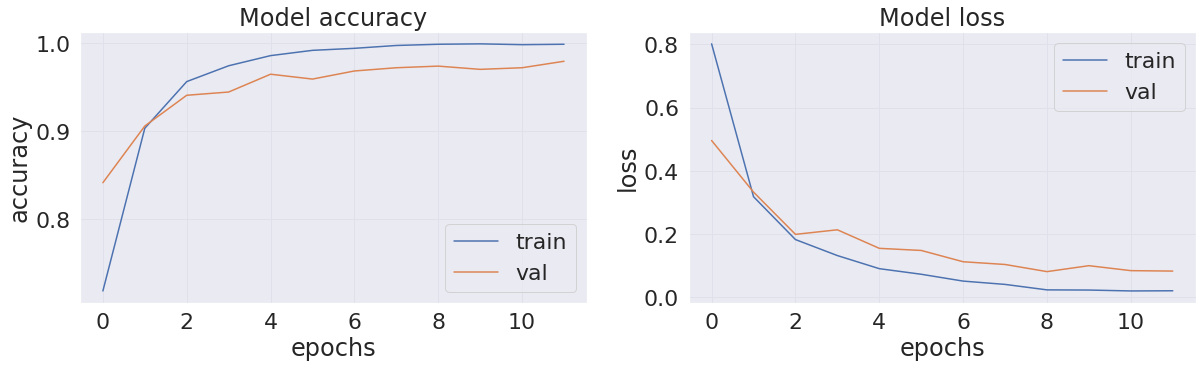

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')

fig.savefig('model1_accuracy_loss',dpi=1200); 

plt.show()

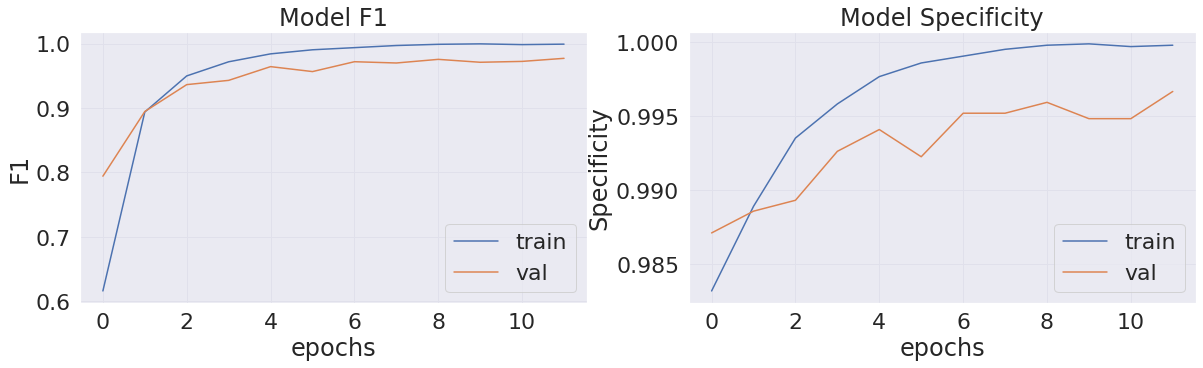

In [21]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'F1','Specificity']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')

fig.savefig('model1_F1_Specificity',dpi=1200); 

plt.show()